<a href="https://colab.research.google.com/github/jaspergass/Tomato-Object-Detection/blob/Start-Training-Branch/Tomato_Object_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tomato Detection Project

Have you ever purchased Tomatoes in bulk? Struggled to pick out the rotten or unripe ones while doing prep for your restaurant or large gathering? Look no further than NAME!

This supervised detection model uses YOLOv8 and object-bounding boxes to analyze photos of groups of tomatoes, easily identifying any outliers.

Clone the git repo into the files of colab so that we can access the paths for our dataset.

In [1]:
!git clone https://github.com/jaspergass/Tomato-Object-Detection.git

Cloning into 'Tomato-Object-Detection'...
remote: Enumerating objects: 1337, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1337 (delta 20), reused 96 (delta 13), pack-reused 1227 (from 1)
Receiving objects: 100% (1337/1337), 237.47 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Updating files: 100% (1349/1349), done.


Import necessary libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

Here, we keep track of the path for where our training, validate, and test folders are located.

In [3]:
#set the paths to labels and images directory
label_dir= "/content/Tomato-Object-Detection/Final_data/labels"
image_dir= "/content/Tomato-Object-Detection/Final_data/images"

Visualizing some sample pictures from the dataset



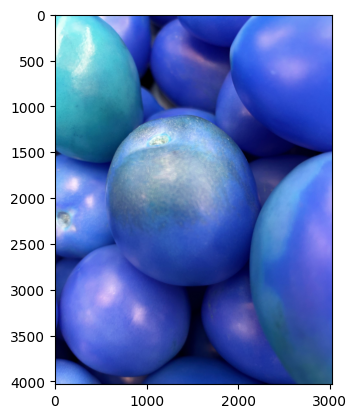

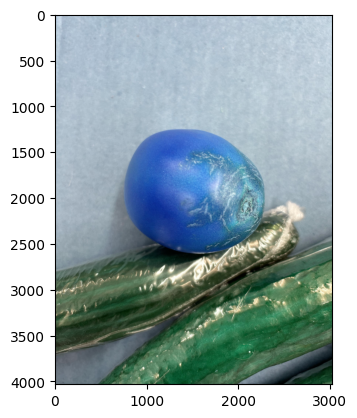

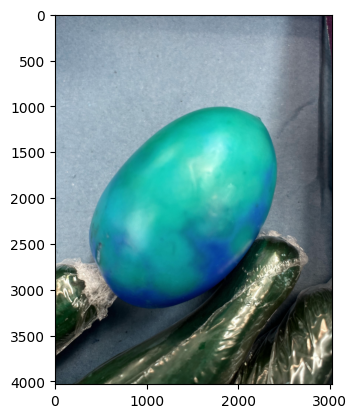

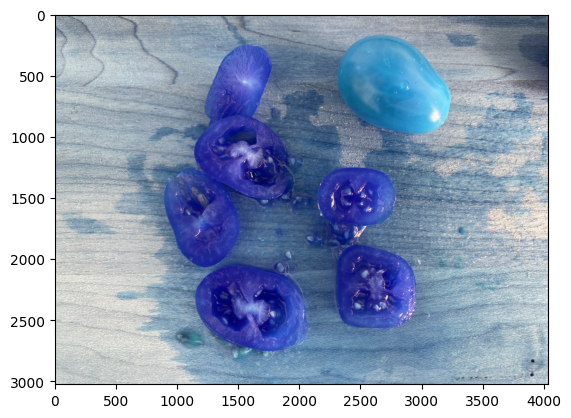

In [4]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "val2"))):
    img = cv2.imread(os.path.join(image_dir,"val2", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

Creating Dataframes from .xml files, from which we will eventually create .txt file for each image

In [5]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

Streaming output truncated to the last 5000 lines.
<Element 'y105' at 0x7f39e2648220>
<Element 'x106' at 0x7f39e2649c10>
<Element 'y106' at 0x7f39e2648180>
<Element 'x107' at 0x7f39e2649df0>
<Element 'y107' at 0x7f39e26481d0>
<Element 'x108' at 0x7f39e2649620>
<Element 'y108' at 0x7f39e264a8e0>
<Element 'x109' at 0x7f39e264a520>
<Element 'y109' at 0x7f39e26480e0>
<Element 'x110' at 0x7f39e2648d60>
<Element 'y110' at 0x7f39e2648130>
<Element 'x111' at 0x7f39e2649f30>
<Element 'y111' at 0x7f39e2648270>
<Element 'x112' at 0x7f39e2648bd0>
<Element 'y112' at 0x7f39e2649e40>
<Element 'x113' at 0x7f39e2649670>
<Element 'y113' at 0x7f39e26484f0>
<Element 'x114' at 0x7f39e26483b0>
<Element 'y114' at 0x7f39e264a3e0>
<Element 'x115' at 0x7f39e26488b0>
<Element 'y115' at 0x7f39e2649800>
<Element 'x116' at 0x7f39e264a070>
<Element 'y116' at 0x7f39e25e5080>
<Element 'x117' at 0x7f39e25e4400>
<Element 'y117' at 0x7f39e25e7ab0>
<Element 'x118' at 0x7f39e25e6430>
<Element 'y118' at 0x7f39e25e6b10>
<Ele

In [6]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

Doing the same with val2

In [7]:
#import glob
#import xml.etree.ElementTree as ET

df3 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/val2" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df3['label'] += [label]
                    df3['width'] += [width]
                    df3['height'] += [height]
                    df3['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df3['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df3['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df3['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df3['ymax'] += [ymax]

/content/Tomato-Object-Detection/Final_data/labels/val2/IMG_8702.xml
<Element 'annotation' at 0x7f39e2649f30>
<Element 'folder' at 0x7f39e26483b0>
<Element 'filename' at 0x7f39e26484f0>
<Element 'path' at 0x7f39e2649670>
<Element 'source' at 0x7f39e264a8e0>
<Element 'database' at 0x7f39e26498a0>
<Element 'size' at 0x7f39e2648130>
<Element 'width' at 0x7f39e26488b0>
<Element 'height' at 0x7f39e264aed0>
<Element 'depth' at 0x7f39e26481d0>
<Element 'object' at 0x7f39e2649c10>
<Element 'name' at 0x7f39e2648220>
<Element 'pose' at 0x7f39e2649620>
<Element 'truncated' at 0x7f39e26493f0>
<Element 'difficult' at 0x7f39e2649df0>
<Element 'bndbox' at 0x7f39e2648270>
<Element 'xmin' at 0x7f39e26480e0>
<Element 'ymin' at 0x7f39e2649760>
<Element 'xmax' at 0x7f39e25d15d0>
<Element 'ymax' at 0x7f39e25d0590>
<Element 'object' at 0x7f39e25d0270>
<Element 'name' at 0x7f39e25d2430>
<Element 'pose' at 0x7f39e25d2610>
<Element 'truncated' at 0x7f39e25d2750>
<Element 'difficult' at 0x7f39e25d3830>
<Element

In [8]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
val2_df=pd.DataFrame(df3)
#df1.head()

# val_df.head()
val2_df

,name,label,width,height,xmin,ymin,xmax,ymax
0,IMG_8702,healthy-tomato,3024,4032,920,1312,1901,2448
1,IMG_8702,healthy-tomato,3024,4032,2163,1243,2813,1877
2,IMG_8702,healthy-tomato,3024,4032,2029,2165,2733,2827
3,IMG_8702,healthy-tomato,3024,4032,1331,2565,2083,3328
4,IMG_8702,healthy-tomato,3024,4032,520,2224,1112,3280
...,...,...,...,...,...,...,...,...
201,IMG_4167,healthy-tomato,4032,3024,1405,479,2324,1184
202,IMG_4167,healthy-tomato,4032,3024,1460,1526,1922,2049
203,IMG_4167,healthy-tomato,4032,3024,2380,1350,2936,1746
204,IMG_4167,healthy-tomato,4032,3024,2380,1735,2903,2297


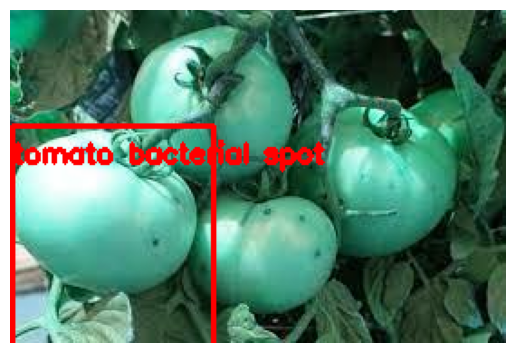

In [9]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Visualizing some images from our data

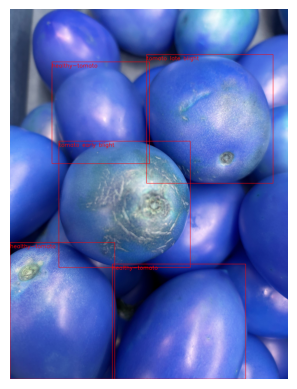

In [30]:
index= 30 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"val2", val2_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (val2_df['xmin'][index], val2_df['ymin'][index]), (val2_df['xmax'][index], val2_df['ymax'][index]), (255, 0, 0), 3)
cv2.rectangle(image, (val2_df['xmin'][index+1], val2_df['ymin'][index+1]), (val2_df['xmax'][index+1], val2_df['ymax'][index+1]), (255, 0, 0), 3)
cv2.rectangle(image, (val2_df['xmin'][index+2], val2_df['ymin'][index+2]), (val2_df['xmax'][index+2], val2_df['ymax'][index+2]), (255, 0, 0), 3)
cv2.rectangle(image, (val2_df['xmin'][index+3], val2_df['ymin'][index+3]), (val2_df['xmax'][index+3], val2_df['ymax'][index+3]), (255, 0, 0), 3)
cv2.rectangle(image, (val2_df['xmin'][index+4], val2_df['ymin'][index+4]), (val2_df['xmax'][index+4], val2_df['ymax'][index+4]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+5], val2_df['ymin'][index+5]), (val2_df['xmax'][index+5], val2_df['ymax'][index+5]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+6], val2_df['ymin'][index+6]), (val2_df['xmax'][index+6], val2_df['ymax'][index+6]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+7], val2_df['ymin'][index+7]), (val2_df['xmax'][index+7], val2_df['ymax'][index+7]), (255, 0, 0), 3)
# cv2.rectangle(image, (val2_df['xmin'][index+8], val2_df['ymin'][index+8]), (val2_df['xmax'][index+8], val2_df['ymax'][index+8]), (255, 0, 0), 3)

# Put label (class_id) near the bbox
label = val2_df["label"][index]
cv2.putText(image, str(label), (val2_df['xmin'][index], val2_df['ymin'][index]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
label2 = val2_df["label"][index+1]
cv2.putText(image, str(label2), (val2_df['xmin'][index+1], val2_df['ymin'][index+1]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
label3 = val2_df["label"][index+2]
cv2.putText(image, str(label3), (val2_df['xmin'][index+2], val2_df['ymin'][index+2]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
label4 = val2_df["label"][index+3]
cv2.putText(image, str(label4), (val2_df['xmin'][index+3], val2_df['ymin'][index+3]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
label5 = val2_df["label"][index+4]
cv2.putText(image, str(label5), (val2_df['xmin'][index+4], val2_df['ymin'][index+4]+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

In [31]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

                                                 name           label  width  \
30  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
31  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
32  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
33  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
34  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
35  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
36  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
37  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
38  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
39  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
40  Riped-tomato_123_jpeg.rf.55b7b84fa15f43a783165...  healthy-tomato    866   
41  Riped-tomato_123_jpeg.rf.55b7b84fa15

Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [32]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    147 non-null    object
 1   label   147 non-null    object
 2   width   147 non-null    int64 
 3   height  147 non-null    int64 
 4   xmin    147 non-null    int64 
 5   ymin    147 non-null    int64 
 6   xmax    147 non-null    int64 
 7   ymax    147 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 9.3+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [33]:
print(train_df['label'].unique())
print(val_df['label'].unique())
print(val2_df['label'].unique())

['tomato early blight' 'tomato late blight' 'tomato bacterial spot'
 'healthy-tomato']
['tomato early blight' 'tomato bacterial spot' 'healthy-tomato'
 'tomato late blight']
['healthy-tomato' 'tomato late blight' 'tomato early blight'
 'tomato bacterial spot']


We need to map labels to class_ids required for YOLO

In [34]:
label_map = {'tomato early blight': 0,
            'tomato late blight': 1,
            'healthy-tomato': 2,
            'tomato bacterial spot': 3}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)
val2_df['class'] = val2_df['label'].map(label_map)

In [35]:
val2_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,IMG_8702,healthy-tomato,3024,4032,920,1312,1901,2448,2
1,IMG_8702,healthy-tomato,3024,4032,2163,1243,2813,1877,2
2,IMG_8702,healthy-tomato,3024,4032,2029,2165,2733,2827,2
3,IMG_8702,healthy-tomato,3024,4032,1331,2565,2083,3328,2
4,IMG_8702,healthy-tomato,3024,4032,520,2224,1112,3280,2


convertig the bounding box format to the one required by YOLO:

In [36]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [37]:
#Validation 2 data
val2_df['x_center'] = (val2_df['xmin']+val2_df['xmax'])/(2*val2_df["width"])
val2_df['y_center'] = (val2_df['ymin']+val2_df['ymax'])/(2*val2_df["height"])
val2_df['box_width'] = (val2_df['xmax']-val2_df['xmin'])/ val2_df["width"]
val2_df['box_height'] = (val2_df['ymax']-val2_df['ymin'])/val2_df["height"]

In [38]:
val2_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,IMG_8702,healthy-tomato,3024,4032,920,1312,1901,2448,2,0.466435,0.466270,0.324405,0.281746
1,IMG_8702,healthy-tomato,3024,4032,2163,1243,2813,1877,2,0.822751,0.386905,0.214947,0.157242
2,IMG_8702,healthy-tomato,3024,4032,2029,2165,2733,2827,2,0.787368,0.619048,0.232804,0.164187
3,IMG_8702,healthy-tomato,3024,4032,1331,2565,2083,3328,2,0.564484,0.730779,0.248677,0.189236
4,IMG_8702,healthy-tomato,3024,4032,520,2224,1112,3280,2,0.269841,0.682540,0.195767,0.261905


Deleting all the sample with Nan values in training and validation data

In [39]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)


before deleting (train data):  (937, 13)
after deleting(train_data):  (937, 13)
before deleting (val data):  (147, 13)
after deleting(val data):  (147, 13)


In [40]:
#validation 2
print("before deleting (val data): " , val2_df.shape)
val2_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val2_df.dropna(inplace=True)
print("after deleting(val2 data): " , val2_df.shape)

before deleting (val data):  (206, 13)
after deleting(val2 data):  (206, 13)


converting the dataframe to type str (string) to be stored in text files.

In [41]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)
val2_df = val2_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [42]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
91,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,30,22,88,74,2,0.2048611111111111,0.2742857142857143,0.2013888888888889,0.29714285714285715
92,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,14,128,90,176,2,0.18055555555555555,0.8685714285714285,0.2638888888888889,0.2742857142857143
93,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,82,115,136,176,2,0.3784722222222222,0.8314285714285714,0.1875,0.3485714285714286
94,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,116,76,168,133,2,0.4930555555555556,0.5971428571428572,0.18055555555555555,0.32571428571428573
95,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,164,66,220,120,2,0.6666666666666666,0.5314285714285715,0.19444444444444445,0.30857142857142855
96,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,104,30,160,88,2,0.4583333333333333,0.33714285714285713,0.19444444444444445,0.3314285714285714
97,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,45,88,105,145,2,0.2604166666666667,0.6657142857142857,0.20833333333333334,0.32571428571428573
98,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,70,62,115,112,2,0.3211805555555556,0.49714285714285716,0.15625,0.2857142857142857
99,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,8,55,54,104,2,0.1076388888888889,0.4542857142857143,0.1597222222222222,0.28
100,images-1-_jpg.rf.d1dcef6f8a31fa1e4a0fcb96a7438fc7,healthy-tomato,288,175,178,114,242,171,2,0.7291666666666666,0.8142857142857143,0.2222222222222222,0.32571428571428573


In [43]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

In [44]:
#VALIDATION 2 DATA
#finding all the unique names:
unique_names= val2_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val2_df[val2_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val2/{name}.txt', 'w') as file:
            file.write(text)

Checking the folders if every image file has a corresponding label file

(We will copy the code, we already used in previous turorial after updating)

In [49]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
val2_images=glob.glob(os.path.join(image_dir, "val2",'*.jpg'))
val2_labels=glob.glob(os.path.join(label_dir, "val2",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] + "." + file.split("/")[-1].split(".")[1] + "." + file.split("/")[-1].split(".")[2] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] + "." + file.split("/")[-1].split(".")[1] + "." + file.split("/")[-1].split(".")[2] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] + "." + file.split("/")[-1].split(".")[1] + "." + file.split("/")[-1].split(".")[2] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] + "." + file.split("/")[-1].split(".")[1] + "." + file.split("/")[-1].split(".")[2] for file in val_labels}
image_files_val2 = {file.split("/")[-1].split(".")[0] for file in val2_images}
label_files_val2 = {file.split("/")[-1].split(".")[0] for file in val2_labels}
#print(image_files_val)



In [50]:
print(len(image_files_train), "  =  ", len(label_files_train))

340   =   340


In [47]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): {'download-7-_jpg.rf.00af7bab3e5eb3f4ad79b408d574e550', 'download-6-_jpg.rf.9538c809926ca03c913ce23cdbf89ec5', 'images-43-_jpg.rf.ca3e50623845ae06b2b6f47fcb3c4cb4', 'download-1-_jpg.rf.31a1c7849f67ac69d90749c333705d6b', 'download-6-_jpg.rf.3488ffc85c46162ab8992676885fd4f0', 'download-10-_jpg.rf.4a9bc3d1e75bc0ebeed4b2d2c71e6fed', 'images-12-_jpg.rf.bf11b2e12c4a78498e41f10fadaeecc8', 'download-2-_jpg.rf.40204744668dea2d515b412a4cfd52d8', 'download-20-_jpg.rf.a982746037663fa58825c67b859fe51e', 'download-17-_jpg.rf.c4349a74a35228f1a63a4891a9c109bb', 'download-3-_jpg.rf.062427ac962ef62e9fb2c28559c8cfa4', 'download-13-_jpg.rf.e130e3d7211cdf9274a1bc01f3a6f803', 'download-20-_jpg.rf.ba8f037ee43a44cdec5c0b04e98a55c3', 'images-12-_jpg.rf.6cb0def9159fd749a51074cb7d53dba4', 'images-5-_jpg.rf.3ee75207b427de07095658194f62effc', 'download-16-_jpg.rf.fbe7e211654cfe496c071caa1e52b369', 'download-9-_jpg.rf.5d1741da9381cd03daf78bcbb8da4754', 'img_p2_6

Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [51]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/Tomato-Object-Detection/Final_data/images/train/download-7-_jpg.rf.00af7bab3e5eb3f4ad79b408d574e550.jpg'

Custom object detection using YOLO

First install and import

In [52]:
%pip install ultralytics
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


#Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [55]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 194MB/s]


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [53]:
%%writefile config.yaml
path: /content/Tomato-Object-Detection/Final_data
train: /content/Tomato-Object-Detection/Final_data/images/train
#test: (test dataset folder path)
val: /content/Tomato-Object-Detection/Final_data/images/val
test: /content/Tomato-Object-Detection/Final_data/labels/val2

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: tomato early blight
  1: tomato late blight
  2: healthy-tomato
  3: tomato bacterial spot

Writing config.yaml


In [56]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 103MB/s]


AMP: checks passed ✅


train: Scanning /content/Tomato-Object-Detection/Final_data/labels/train... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<00:00, 1513.83it/s]

train: New cache created: /content/Tomato-Object-Detection/Final_data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/Tomato-Object-Detection/Final_data/labels/val... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 1712.15it/s]

val: New cache created: /content/Tomato-Object-Detection/Final_data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.21G     0.9614      2.281      1.322         45        640: 100%|██████████| 43/43 [00:12<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all         54        147      0.614      0.506      0.577      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G     0.9457      1.572      1.235         19        640: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all         54        147      0.546      0.547      0.623      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       2.2G     0.9052      1.367      1.231         36        640: 100%|██████████| 43/43 [00:07<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.20it/s]

                   all         54        147      0.591      0.723      0.731      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.18G      0.892      1.187      1.238         18        640: 100%|██████████| 43/43 [00:10<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.00it/s]

                   all         54        147      0.725      0.757      0.781      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.19G      0.849      1.163      1.211         37        640: 100%|██████████| 43/43 [00:07<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.31it/s]

                   all         54        147      0.806       0.71      0.854      0.634



5 epochs completed in 0.017 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


                   all         54        147      0.806       0.71      0.854      0.634
   tomato early blight         14         52      0.608      0.885      0.822      0.681
    tomato late blight         18         33      0.876      0.429      0.757      0.508
        healthy-tomato         10         36      0.782      0.833      0.894      0.621
 tomato bacterial spot         12         26      0.959      0.692      0.943      0.726
Speed: 0.3ms preprocess, 7.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f38d4a29ba0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

#Evaluation Metrics



Choosing the Right Metrics

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.



In [57]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/Tomato-Object-Detection/Final_data/labels/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


                   all         54        147      0.807      0.709      0.853      0.636
   tomato early blight         14         52      0.606      0.885      0.819      0.679
    tomato late blight         18         33      0.876      0.427      0.763      0.517
        healthy-tomato         10         36      0.785      0.833      0.895      0.617
 tomato bacterial spot         12         26       0.96      0.692      0.936      0.733
Speed: 0.7ms preprocess, 41.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train2


0.7093859737007102

Showing confusion matrix

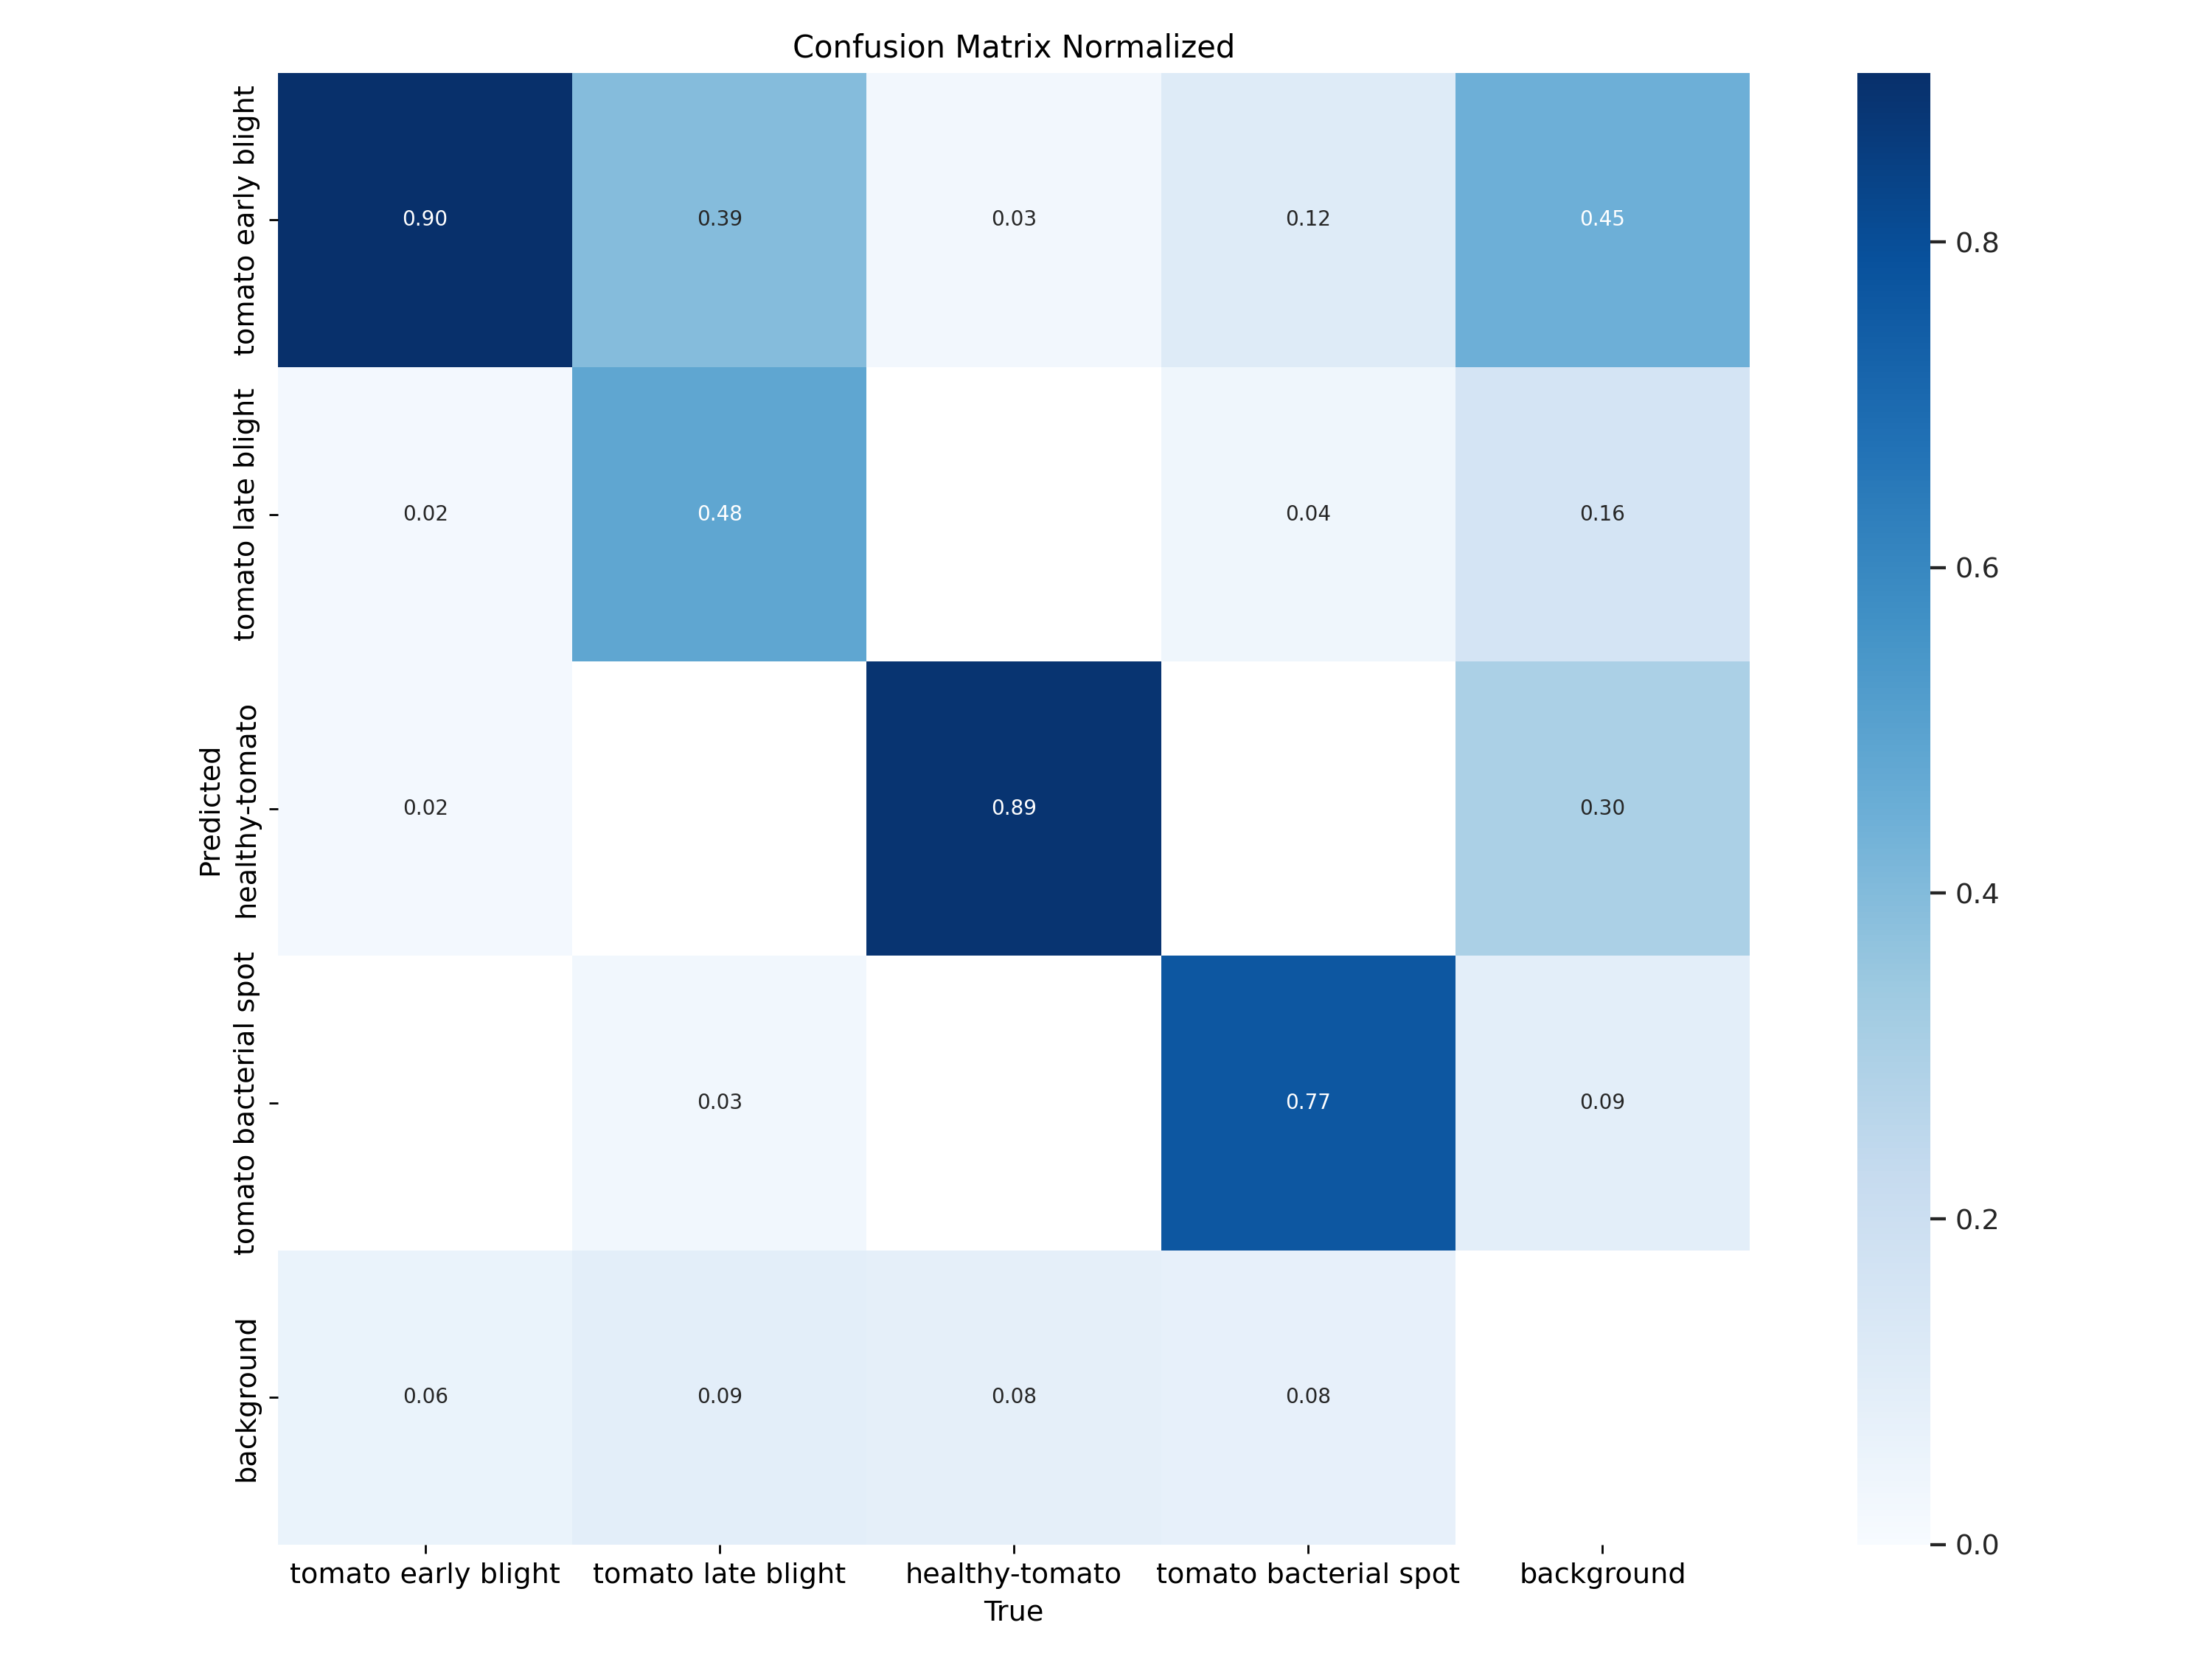

In [59]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train2/confusion_matrix_normalized.png')

In [60]:
results = model('/content/WholeFoods-9230cb2e4a4c4ad69029fe1ce8d3e38f.jpg', save=True)
# image = Image.open('/content/runs/detect/train25/Screenshot 2024-11-01 at 1.31.42 PM.png')

FileNotFoundError: /content/WholeFoods-9230cb2e4a4c4ad69029fe1ce8d3e38f.jpg does not exist